# Imports and Settings

In [2]:
import itertools
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
import warnings

warnings.simplefilter(action='ignore', category=Warning)

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_55380/117359726.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Enable diagrams to visualize pipelines
# Set output from transformers to DataFrames
from sklearn import set_config
set_config(display="diagram", transform_output="pandas")

In [4]:
# Enable imports from parent directory
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

In [5]:
from graph_utils import *

# Load Data

In [6]:
df = pd.read_csv("data/census_us.csv")

In [7]:
df.sample(5)

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
35088,52,Private,24740.0,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,1740.0,55.0,<=50K
37776,53,Private,214868.0,Assoc-voc,Never-married,Adm-clerical,Other-relative,Black,Female,0.0,2001.0,40.0,<=50K
27256,54,Private,172962.0,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Male,0.0,1340.0,40.0,<=50K
37512,66,Self-emp-not-inc,99927.0,HS-grad,Widowed,Tech-support,Not-in-family,White,Female,0.0,0.0,45.0,<=50K
4351,47,Federal-gov,99549.0,Some-college,Divorced,Adm-clerical,Unmarried,Black,Female,0.0,0.0,40.0,<=50K


# EDA

## Duplicates

In [8]:
df.duplicated().sum()

40

👉 **What to do with these duplicates?**

In [9]:
df.drop(['fnlwgt'], axis=1, inplace=True)

## Missing Values

In [10]:
df.isna().sum()

age               0
workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
income            0
dtype: int64

In [11]:
cat_cols = df.select_dtypes(include="object")
for cat in cat_cols:
    print(cat)
    display(df[cat].unique())
    print()

workclass


array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', '?', 'Without-pay', 'Never-worked'],
      dtype=object)


education


array(['Bachelors', 'HS-grad', '11th', 'Masters', 'Some-college',
       'Assoc-acdm', 'Doctorate', '9th', 'Assoc-voc', '10th', '7th-8th',
       'Prof-school', '1st-4th', 'Preschool', '5th-6th', '12th'],
      dtype=object)


marital_status


array(['Never-married', 'Married-civ-spouse', 'Divorced', 'Separated',
       'Married-AF-spouse', 'Widowed', 'Married-spouse-absent'],
      dtype=object)


occupation


array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Sales', 'Farming-fishing', 'Machine-op-inspct',
       'Other-service', 'Transport-moving', 'Tech-support',
       'Craft-repair', 'Protective-serv', '?', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)


relationship


array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)


race


array(['White', 'Black', 'Other', 'Asian-Pac-Islander',
       'Amer-Indian-Eskimo'], dtype=object)


sex


array(['Male', 'Female'], dtype=object)


income


array(['<=50K', '>50K'], dtype=object)

👉 There are missing values in `workclass` and `occupation`

In [12]:
df.query("workclass == '?' and occupation == '?'")

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
56,25,?,Some-college,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,<=50K
63,67,?,10th,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,2.0,<=50K
89,17,?,10th,Never-married,?,Own-child,White,Female,34095.0,0.0,32.0,<=50K
109,35,?,HS-grad,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,40.0,<=50K
128,43,?,Some-college,Divorced,?,Not-in-family,White,Female,0.0,0.0,40.0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
43682,21,?,Some-college,Never-married,?,Other-relative,White,Female,0.0,0.0,52.0,<=50K
43686,61,?,Some-college,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,14.0,<=50K
43765,21,?,Some-college,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,<=50K
43803,81,?,Assoc-voc,Married-civ-spouse,?,Husband,White,Male,2936.0,0.0,20.0,<=50K


In [13]:
df.query("workclass == '?' and occupation != '?'")

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income


In [14]:
df.query("workclass != '?' and occupation == '?'")

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
4788,18,Never-worked,10th,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,<=50K
9689,23,Never-worked,7th-8th,Divorced,?,Not-in-family,White,Male,0.0,0.0,35.0,<=50K
13210,17,Never-worked,10th,Never-married,?,Own-child,White,Male,0.0,0.0,30.0,<=50K
18221,18,Never-worked,11th,Never-married,?,Own-child,White,Female,0.0,0.0,10.0,<=50K
20810,20,Never-worked,Some-college,Never-married,?,Own-child,Black,Male,0.0,0.0,40.0,<=50K
28945,30,Never-worked,HS-grad,Married-civ-spouse,?,Wife,Black,Female,0.0,0.0,40.0,<=50K
28951,18,Never-worked,Some-college,Never-married,?,Own-child,White,Male,0.0,0.0,4.0,<=50K
37107,17,Never-worked,11th,Never-married,?,Own-child,Black,Female,0.0,0.0,20.0,<=50K
39648,20,Never-worked,HS-grad,Married-spouse-absent,?,Other-relative,White,Male,0.0,0.0,35.0,<=50K
41687,18,Never-worked,11th,Never-married,?,Own-child,White,Male,0.0,0.0,35.0,<=50K


In [15]:
df.query("workclass == 'Never-worked' and occupation != '?'")

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income


In [16]:
num_cols = df.select_dtypes(exclude='object').columns
cat_cols = df.select_dtypes(include='object').columns

## Monovariate Analysis

#### Original Distributions

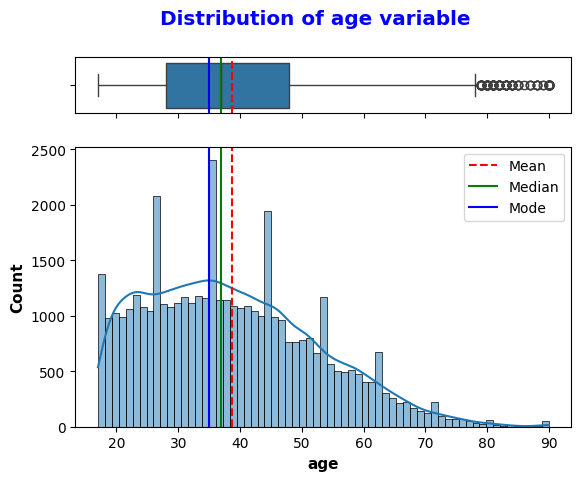

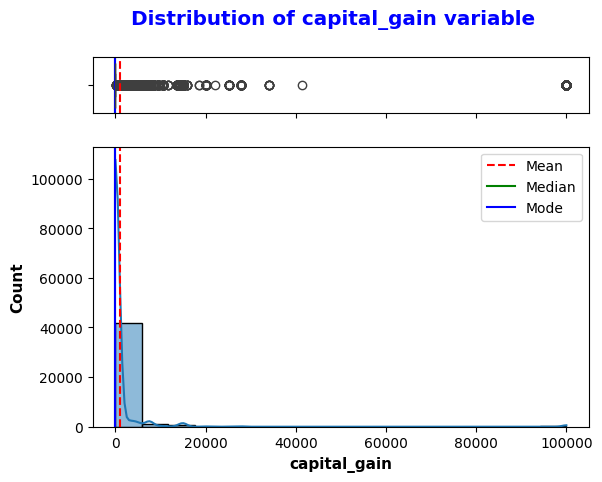

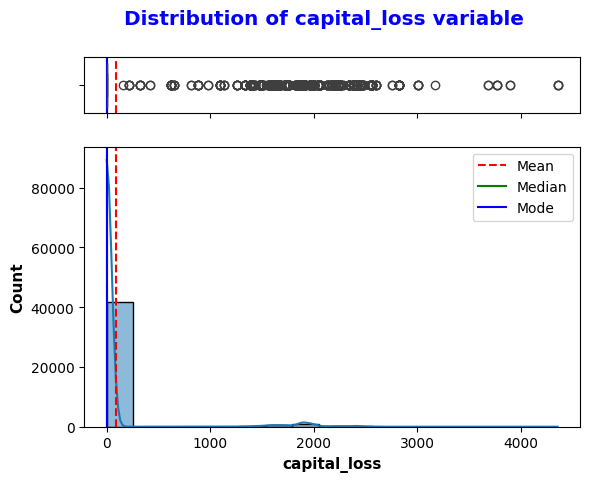

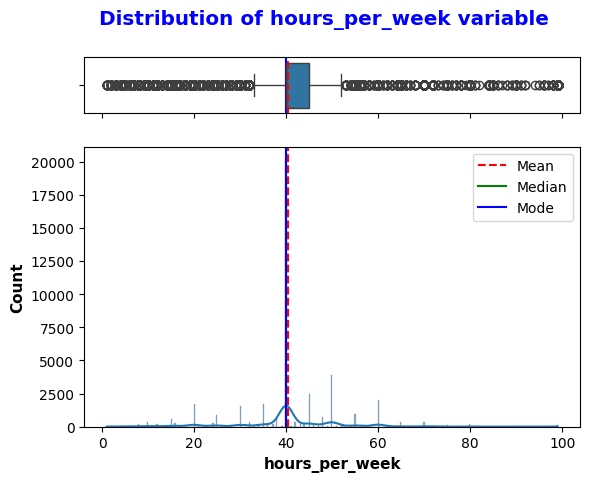

In [17]:
for col in num_cols:
    hist_box_plot(df, col)

#### "Logged" Distributions

In [18]:
df_log = pd.DataFrame()

for col in num_cols:
    df_log[f"log1_{col}"] = df[col].apply(np.log1p)

df_log

,log1_age,log1_capital_gain,log1_capital_loss,log1_hours_per_week
0,3.688879,7.684784,0.0,3.713572
1,3.931826,0.000000,0.0,2.639057
2,3.663562,0.000000,0.0,3.713572
3,3.988984,0.000000,0.0,3.713572
4,3.637586,0.000000,0.0,3.713572
...,...,...,...,...
43827,3.688879,0.000000,0.0,3.610918
43828,4.174387,0.000000,0.0,3.713572
43829,3.663562,0.000000,0.0,3.931826
43830,3.806662,8.604471,0.0,3.713572


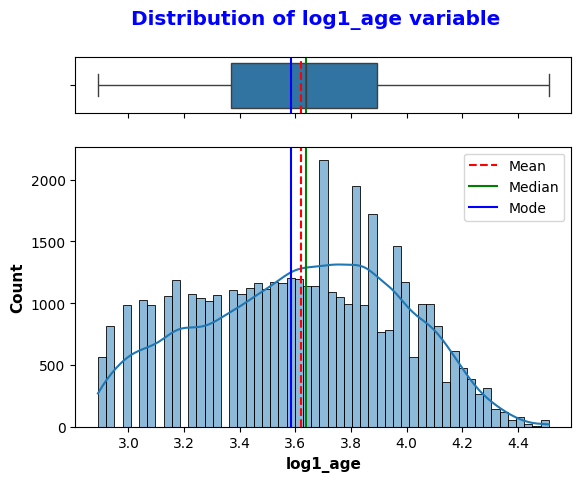

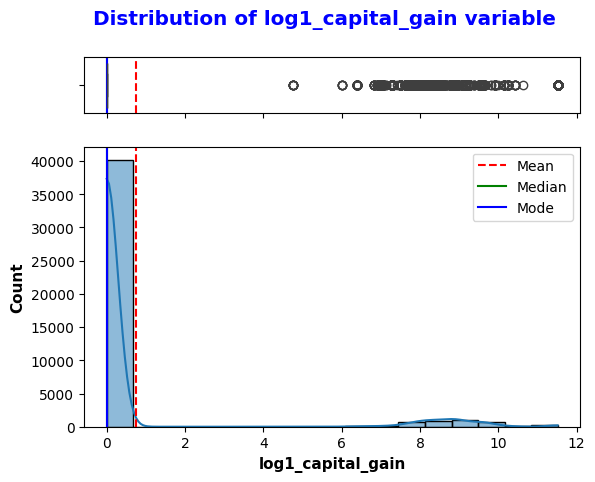

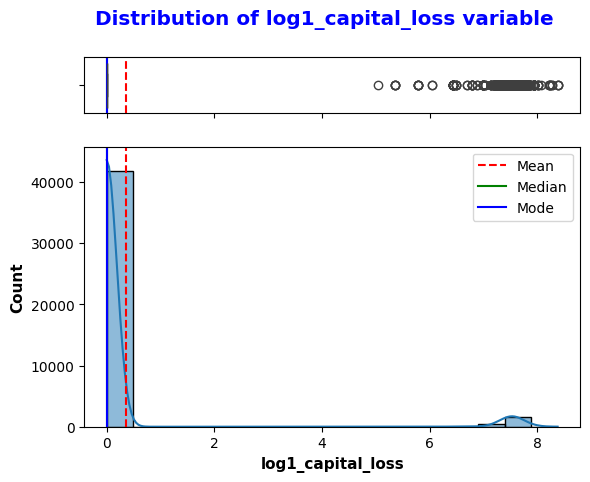

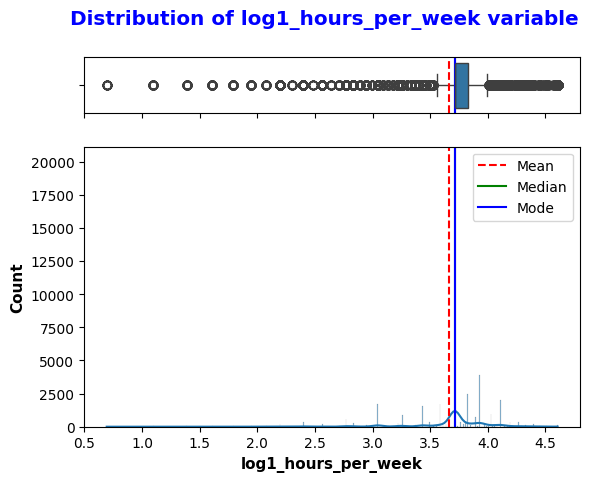

In [19]:
for col in df_log.columns:
    hist_box_plot(df_log, col)

#### *"rooted"* distributions

In [20]:
df_sqr = pd.DataFrame()

for col in num_cols:
    df_sqr[f"sqr_{col}"] = df[col].apply(np.sqrt)

df_sqr

,sqr_age,sqr_capital_gain,sqr_capital_loss,sqr_hours_per_week
0,6.244998,46.626173,0.0,6.324555
1,7.071068,0.000000,0.0,3.605551
2,6.164414,0.000000,0.0,6.324555
3,7.280110,0.000000,0.0,6.324555
4,6.082763,0.000000,0.0,6.324555
...,...,...,...,...
43827,6.244998,0.000000,0.0,6.000000
43828,8.000000,0.000000,0.0,6.324555
43829,6.164414,0.000000,0.0,7.071068
43830,6.633250,73.857972,0.0,6.324555


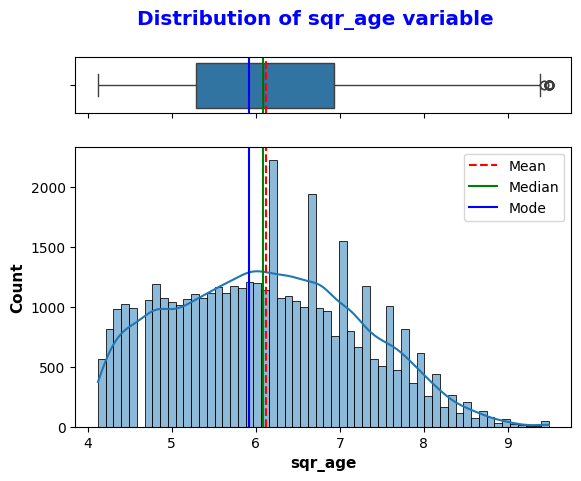

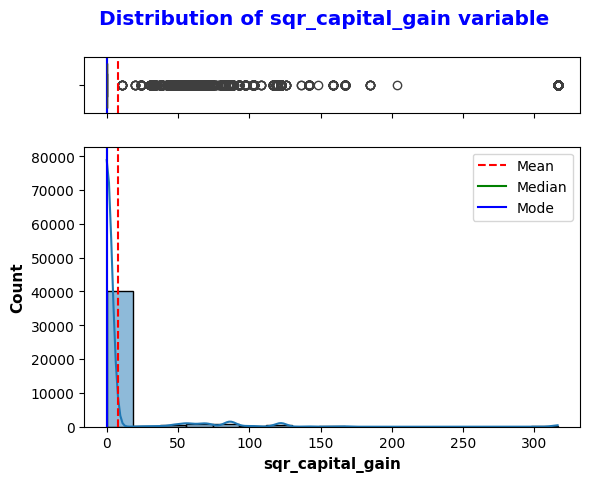

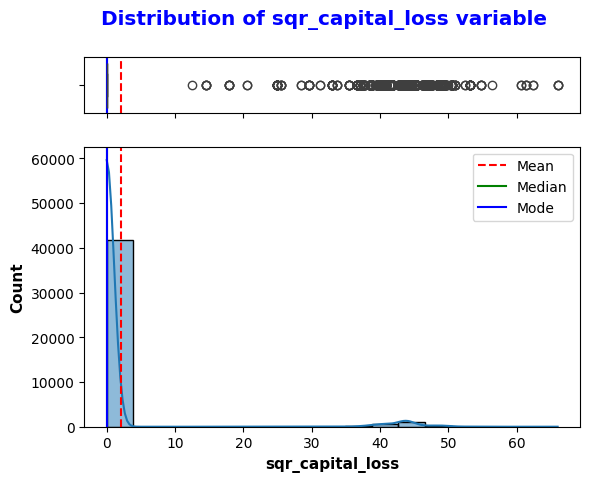

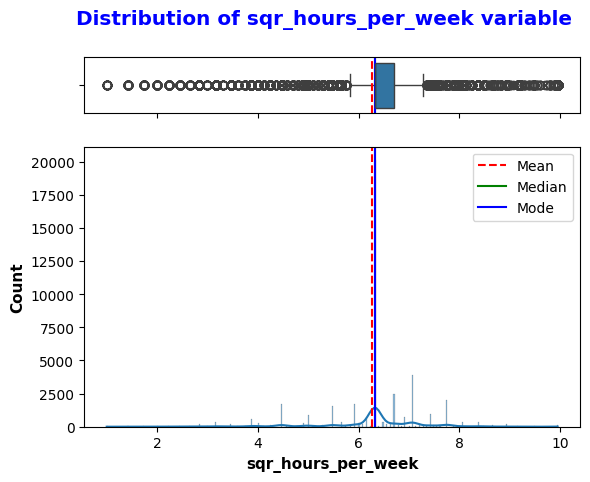

In [21]:
for col in df_sqr.columns:
    hist_box_plot(df_sqr, col)

#### Studying Some Variables More Precisely

In [22]:
df.hours_per_week.describe()

count    43832.000000
mean        40.440774
std         12.471352
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64

In [23]:
df.hours_per_week.unique()

array([40., 13., 45., 50., 80., 30., 35., 60., 20., 52., 44., 15., 25.,
       43., 38., 55., 48., 58., 32., 70.,  2., 22., 56., 41., 28., 36.,
       24., 46., 42., 16., 12., 65.,  1., 10., 34., 98., 33., 54.,  8.,
        6., 64., 19., 18.,  5.,  9., 47., 37., 21., 26., 14.,  4., 72.,
        7., 99., 75., 53., 39., 62., 59., 57., 90., 66., 11., 49., 84.,
        3., 17., 68., 27., 85., 31., 78., 51., 63., 23., 87., 88., 73.,
       89., 97., 94., 29., 77., 96., 67., 82., 86., 91., 81., 76., 92.,
       61., 74., 95., 79.])

In [24]:
df.capital_loss.describe()

count    43832.000000
mean        88.789743
std        405.539243
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64

In [25]:
df.capital_loss.nunique()

97

In [26]:
df.capital_loss.value_counts()

capital_loss
0.0       41752
1902.0      277
1977.0      231
1887.0      216
1485.0       64
          ...  
3175.0        1
2467.0        1
155.0         1
2489.0        1
2163.0        1
Name: count, Length: 97, dtype: int64

In [27]:
df.capital_gain.describe()

count    43832.000000
mean      1089.626529
std       7455.791326
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

In [28]:
df.capital_gain.value_counts()

capital_gain
0.0        40146
15024.0      465
7688.0       379
7298.0       335
99999.0      219
           ...  
22040.0        1
1111.0         1
7262.0         1
1731.0         1
6612.0         1
Name: count, Length: 123, dtype: int64

### Categorical Features

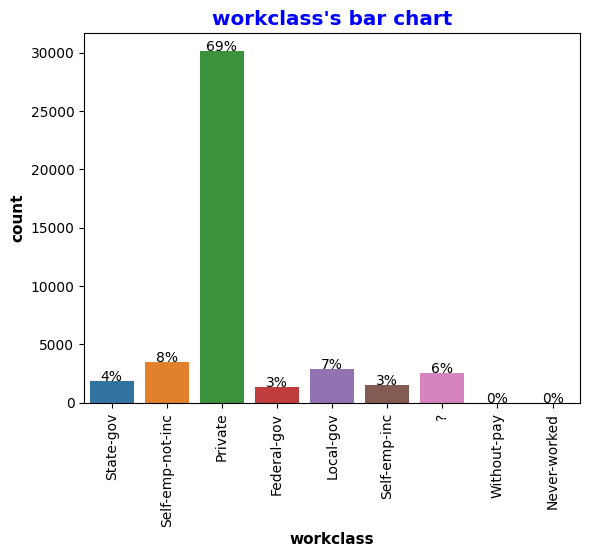

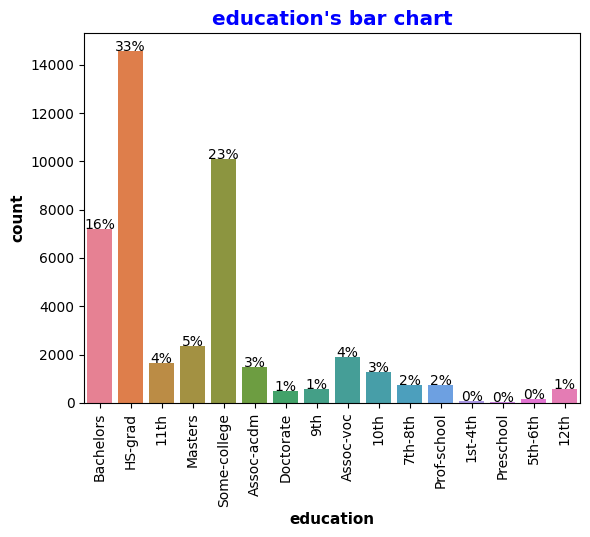

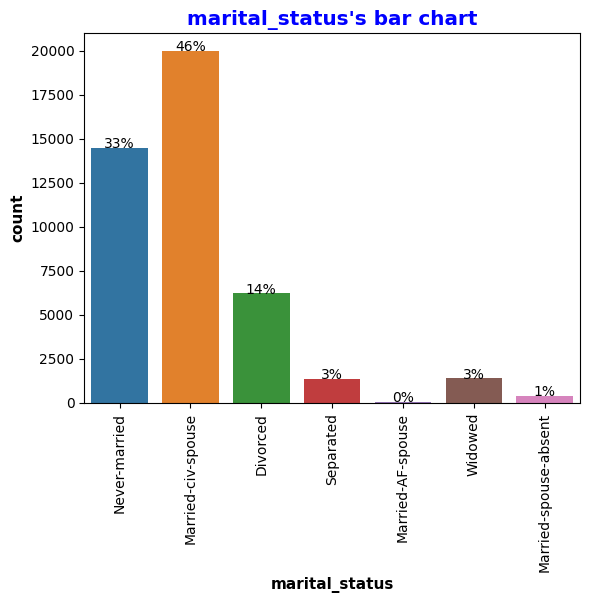

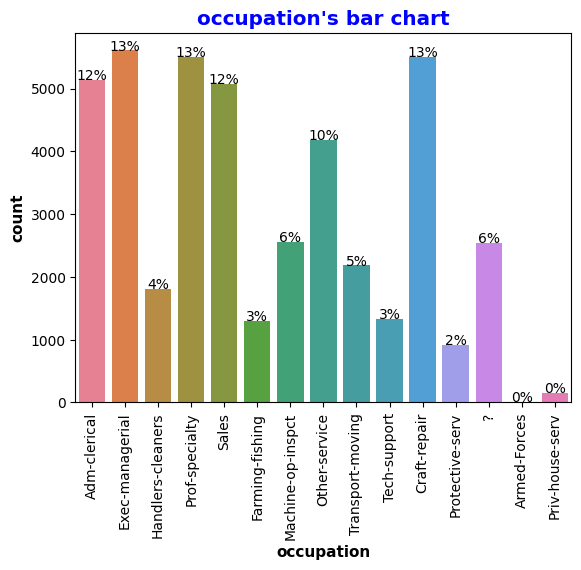

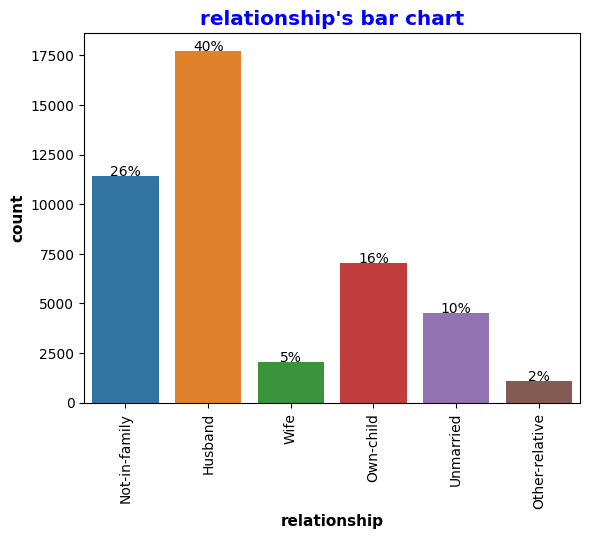

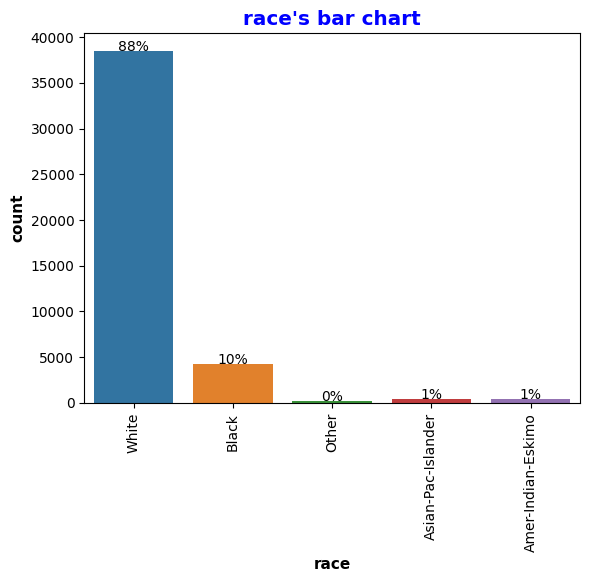

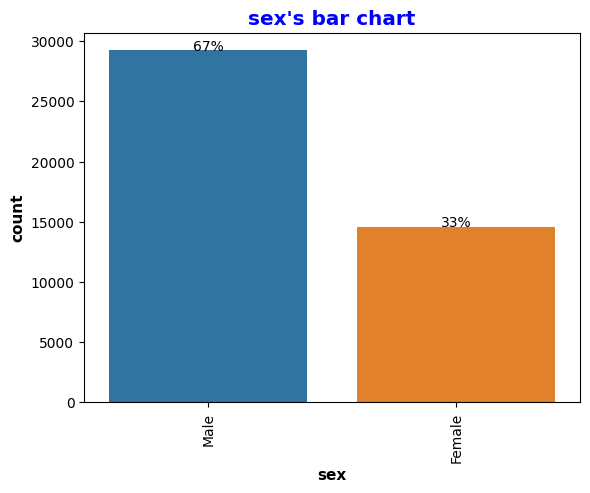

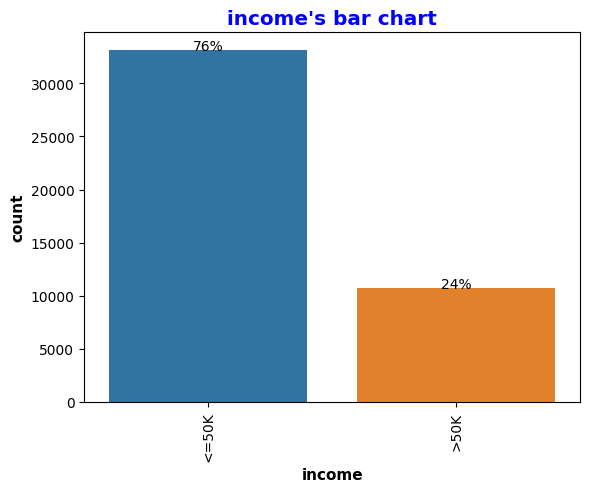

In [29]:
for col in cat_cols:
    bar_chart(df, col)

## Bivariate Analysis

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43832 entries, 0 to 43831
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             43832 non-null  int64  
 1   workclass       43832 non-null  object 
 2   education       43832 non-null  object 
 3   marital_status  43832 non-null  object 
 4   occupation      43832 non-null  object 
 5   relationship    43832 non-null  object 
 6   race            43832 non-null  object 
 7   sex             43832 non-null  object 
 8   capital_gain    43832 non-null  float64
 9   capital_loss    43832 non-null  float64
 10  hours_per_week  43832 non-null  float64
 11  income          43832 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 4.0+ MB


## Numerical Variables

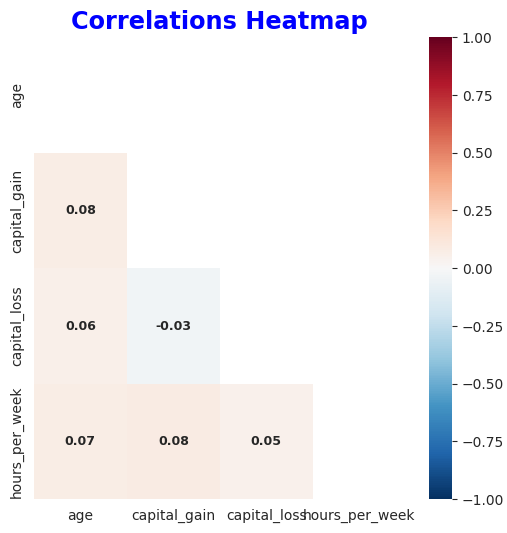

In [31]:
correlation_heatmap(df)

## Categorical Variables

In [32]:
cat_combinations = list(itertools.combinations(cat_cols[::-1], 2))
cat_combinations

[('income', 'sex'),
 ('income', 'race'),
 ('income', 'relationship'),
 ('income', 'occupation'),
 ('income', 'marital_status'),
 ('income', 'education'),
 ('income', 'workclass'),
 ('sex', 'race'),
 ('sex', 'relationship'),
 ('sex', 'occupation'),
 ('sex', 'marital_status'),
 ('sex', 'education'),
 ('sex', 'workclass'),
 ('race', 'relationship'),
 ('race', 'occupation'),
 ('race', 'marital_status'),
 ('race', 'education'),
 ('race', 'workclass'),
 ('relationship', 'occupation'),
 ('relationship', 'marital_status'),
 ('relationship', 'education'),
 ('relationship', 'workclass'),
 ('occupation', 'marital_status'),
 ('occupation', 'education'),
 ('occupation', 'workclass'),
 ('marital_status', 'education'),
 ('marital_status', 'workclass'),
 ('education', 'workclass')]

In [33]:
len(cat_combinations)

28

In [34]:
for idx, (var1, var2) in enumerate(cat_combinations, 1):
    ct = contingency_table(var1, var2, df)
    chi2, p, dof, expected = chi2_contingency(ct)

    if p < 0.05:
        print(f"{idx}) Correlation between {var1} and {var2}, with {chi2=:.3f}")
    else:
        print(f"No correlation between {var1} and {var2}")

1) Correlation between income and sex, with chi2=2118.214
2) Correlation between income and race, with chi2=455.101
3) Correlation between income and relationship, with chi2=9343.697


4) Correlation between income and occupation, with chi2=5220.600
5) Correlation between income and marital_status, with chi2=9147.397
6) Correlation between income and education, with chi2=5742.309
7) Correlation between income and workclass, with chi2=1358.624
8) Correlation between sex and race, with chi2=628.036
9) Correlation between sex and relationship, with chi2=18399.586
10) Correlation between sex and occupation, with chi2=8096.471
11) Correlation between sex and marital_status, with chi2=9490.727
12) Correlation between sex and education, with chi2=377.590
13) Correlation between sex and workclass, with chi2=1060.618
14) Correlation between race and relationship, with chi2=1739.563
15) Correlation between race and occupation, with chi2=1137.164
16) Correlation between race and marital_status, with chi2=1212.929
17) Correlation between race and education, with chi2=640.685
18) Correlation between race and workclass, with chi2=656.460
19) Correlation between relationship and oc

# Modeling

## Separate Features and Target

In [35]:
X = df.copy()
y = X.pop("income")
X

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0
4,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
43827,39,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0
43828,64,?,HS-grad,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0
43829,38,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0
43830,44,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0


## Hold-Out

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=69
)

## Encode Target

In [37]:
lab_enc = LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.fit_transform(y_test)

### Création des OHE

In [38]:
bin_feats = ['sex']
nom_feats = ['workclass', 'marital_status', 'occupation', 'relationship', 'race']
ord_feats = ['education']

#ohe_nom =      # OHE pour les colonnes nominales nom_feats
#ohe_bin =      # OHE pour les colonnes binaire bin_feats

educ_cats = [[
    "Preschool",
    "1st-4th grade",
    "5th-6th grade",
    "7th-8th grade",
    "9th grade",
    "10th grade",
    "11th grade",
    "12th grade",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
    "Prof-school"
]]

#ord_enc =      # OHE pour les colonnes binaire educ_cats

In [39]:
# transformers = ColumnTransformer(
#    ...
# )

#### Préparation du scaler, de l'estimateur et de la feature selection

In [40]:
# Créez ici vos différents éléments de la pipeline
# Pour la feature selection, vous pouvez choisir entre chi2 ou f_classif et ajouter, si vous le voulez, un VarianceThreshold
# Le scaler n'est pas obligatoire

# feature_selection = 
# scaler = 
# estimator = 

### Test de performance

Ici, on teste la performance que va apporter notre feature selection au temps d'entrainement de notre modèle sans perte de score

#### Sans feature selection

In [41]:
from sklearn.metrics import classification_report

# start =           # Utilisez la librairie time de python
# pipe =            # création du pipeline avec les différents éléments qu'on a préparé au-dessus
# pipe.fit(X_train, y_train)
# stop =            # Utilisez la librairie time de python

# print('Nb colonnes: ', ....) # Slicez le pipe pour afficher le nombre de colonnes qu'il retourne (n'oubliez pas le fit_transform)
# print(f"Training time: {.....}s") # Utilisez start et stop pour afficher le temps d'entrainement du modèle

# y_pred = pipe.predict(X_test)

# print(classification_report(y_test, y_pred))

#### Avec feature selection

In [42]:
# start =           # Utilisez la librairie time de python
# pipe =            # création du pipeline avec les différents éléments qu'on a préparé au-dessus + feature selection
# pipe.fit(X_train, y_train)
# stop =            # Utilisez la librairie time de python

# print('Nb colonnes: ', ....) # Slicez le pipe pour afficher le nombre de colonnes qu'il retourne (n'oubliez pas le fit_transform)
# print(f"Training time: {.....}s") # Utilisez start et stop pour afficher le temps d'entrainement du modèle

# y_pred = pipe.predict(X_test)

# print(classification_report(y_test, y_pred))

## Feature Importance

### Récupération des labels des colonnes

In [ ]:
X_train_transf = pipe[:-1].fit_transform(X_train, y_train)
feat_labels = X_train_transf.columns
feat_labels

### Affichage des feature importance

In [43]:
f = pd.DataFrame({'features': np.array(list(feat_labels)), 'score': pipe.named_steps['gradientboostingclassifier'].feature_importances_})
f.sort_values(by=['score'], ascending=False, inplace=True)
f

ValueError: could not convert string to float: 'Self-emp-inc'